In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ms_stim_analysis.Analysis.utils import (
    filter_opto_data,
    get_running_valid_intervals,
    bootstrap_traces,
)
from ms_stim_analysis.AnalysisTables.decoding_tables import (
    ClusterlessAheadBehindDistance,
)
from ms_stim_analysis.AnalysisTables.credible_intervals import (
    CredibleInterval,
    CredibleIntervalSelection,
)
from ms_stim_analysis.AnalysisTables.place_fields import TrackCellCoverage

from ms_stim_analysis.Style.style_guide import animal_style, transfection_style
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.common import interval_list_contains, interval_list_contains_ind
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup

from ms_stim_analysis.AnalysisTables.valid_decode_times import (
    ClusterlessValidDecodeTimes,
)
from ms_stim_analysis.AnalysisTables.location_times import (
    LocationTimes,
    LocationTimesSelection,
    LocationTimesParams,
)

from ms_stim_analysis.AnalysisTables.ms_task_performance import (
    AlternationTaskPerformance,
)
from ms_stim_analysis.AnalysisTables.ms_dio_event import DioEvents, ProcessedDioEvents

from ms_stim_analysis.AnalysisTables.ms_task_identification import TaskIdentification
from ms_stim_analysis.AnalysisTables.ms_interval import EpochIntervalListName
from spyglass.common import interval_list_contains_ind

from tqdm import tqdm
import pandas as pd

In [3]:
# make interval of all choice point times across all animals (none are overlapping in unix time so ok)
from spyglass.common.common_interval import Interval

LocationTimesSelection().parents()
query = LocationTimes() & "location_params_name LIKE 'ms_%_choice_point'"

choice_intervals = Interval(np.concatenate(query.fetch("intervals")))

# np.unique(LocationTimes().fetch("location_params_name"))

In [ ]:
dlc_pos = True
posterior_fit = "causal"
compiled_results = []
animal_list = [
    "Winnie",
]  # "Yoshi"]
animal_list = animal_style.index

animal_list = ["transfected", "control"]
spikes_delta_t = 0.0005
plot_ind = np.arange(-35, 35, 1)
spikes_window = int(plot_ind[-1] * (0.002 / spikes_delta_t))
spikes_plot_ind = np.arange(-spikes_window, spikes_window, 1)

for animal in animal_list:
    dataset_key = {
        "animal": animal,
        "track_type": "early_wtrack",
        # "track_type": "lineartrack",
        # "period_ms": 100,
        "min_pulse_length": 20,
    }
    if animal in [x["animal"] for x in compiled_results]:
        continue

    dataset = filter_opto_data(dataset_key)
    dataset = dataset.proj(decoding_interval="interval_list_name")
    dataset = ClusterlessValidDecodeTimes() & dataset
    if dlc_pos:
        dataset = dataset & "position_group_name LIKE 'DLC%'"
    if not dataset:
        continue

    ahead_behind = []
    inbound_stim = []
    outbound_stim = []
    for ii, key in enumerate(tqdm(dataset.fetch("KEY")[:])):
        # get the good stim times
        stim = np.array(
            (ClusterlessValidDecodeTimes() & key).fetch1("valid_stim_times")
        )
        stim = choice_intervals.contains(stim)
        if len(stim) == 0:
            continue
        if not (ClusterlessAheadBehindDistance() & key):
            continue
        track_key = {
            "nwb_file_name": key["nwb_file_name"],
            "decode_group_name": key["position_group_name"],
        }
        track_query = TrackCellCoverage & track_key
        if not track_query:
            continue
        good_coverage_times = track_query.fetch_good_coverage_times()
        stim = interval_list_contains(good_coverage_times, np.array(stim))
        if len(stim) == 0:
            continue
        results = (ClusterlessDecodingV1 & key).fetch_results()
        timestamps = results.time
        ind_on = np.digitize(stim, timestamps)
        if len(ind_on) == 0:
            continue

        # get the ahead-behind distance across good stims
        ahead_behind_df = (ClusterlessAheadBehindDistance() & key).fetch1_dataframe()
        ahead_behind.extend(
            [
                ahead_behind_df["decode_distance"].values[ind + plot_ind]
                for ind in ind_on
            ]
        )

        # assign each stime to inbound or outbound trial
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName) & key).fetch(
            "performance_outcomes"
        )

        outcomes = outcomes[0]

        poke_times = (
            (ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName) & key
        ).fetch1("dio_first_poke_times")
        last_poke_times = (
            (ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key
        ).fetch1("dio_last_poke_times")
        inbound_trial = [("inbound" in x) for x in outcomes[1:]]
        outbound_trial = [("outbound" in x) for x in outcomes[1:]]
        # accuracy.extend([("incorrect" in x) for x in outcomes[1:]])

        trial_intervals = np.array(
            [[poke_times[i], poke_times[i + 1]] for i in range(len(poke_times) - 1)]
        )
        inbound_intervals = trial_intervals[inbound_trial]
        outbound_intervals = trial_intervals[outbound_trial]

        inbound_stim_i = np.zeros(len(stim)).astype(bool)
        outbound_stim_i = np.zeros(len(stim)).astype(bool)
        ind_inbound = interval_list_contains_ind(inbound_intervals, np.array(stim))
        ind_outbound = interval_list_contains_ind(outbound_intervals, np.array(stim))
        if ind_inbound.size:
            inbound_stim_i[ind_inbound] = True
        if ind_outbound.size:
            outbound_stim_i[ind_outbound] = True

        inbound_stim.extend(inbound_stim_i)
        outbound_stim.extend(outbound_stim_i)

    ahead_behind = np.array(ahead_behind)
    compiled_results.append(
        {
            "animal": animal,
            "ahead_behind": ahead_behind,
            "inbound_stim": np.array(inbound_stim),
            "outbound_stim": np.array(outbound_stim),
        }
    )

compiled_results = pd.DataFrame(compiled_results)

datasets: 44


  0%|          | 0/28 [00:00<?, ?it/s][09:38:59][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
[2025-09-09 09:38:59,386][WARNING]: Skipped checksum for file with hash: f16f137d-706e-b69f-7026-808cae7a30cc, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_dbc0d72d-7679-4afe-8848-b991555ed9a9.nc
[09:39:19][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead
[09:39:19][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead
  7%|▋         | 2/28 [00:20<04:25, 10.20s/it][09:39:19][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
[2025-09-09 09:39:19,578][WARNING]: Skipped checksum for file with hash: 6a8ce79d-ca7f-6f88-c726-97f90f99196a, and path: /stelmo/nwb/analysis/Frodo20230814/Frodo20230814_c09ab3a7-fb36-44d9-a1d1-

datasets: 42


  0%|          | 0/40 [00:00<?, ?it/s][09:42:58][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
  5%|▌         | 2/40 [00:00<00:03, 11.61it/s][09:42:58][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
 10%|█         | 4/40 [00:00<00:03, 10.96it/s][09:42:58][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
 15%|█▌        | 6/40 [00:00<00:03, 10.72it/s][09:42:58][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains
	Use Interval.contains instead
[2025-09-09 09:42:58,909][WARNING]: Skipped checksum for file with hash: f9ee702c-b72f-432b-be8f-c9e74cdf5ae9, and path: /stelmo/nwb/analysis/Bilbo20230802/Bilbo20230802_6b60fa1e-4fa4-4d78-a6cf-47391e87dddf.nc
 15%|█▌        | 6/40 [00:10<00:03, 10.72it/s][09:43:17][WARNING] Spyglass: DEPRECATION scheduled for Spyglass

transfected 5.520491123053324
control 5.315890409158643
0.18803360011411827


Text(0.5, 1.0, 'ahead-behind distance: max_distance in 0 to 50 ms around pulse')

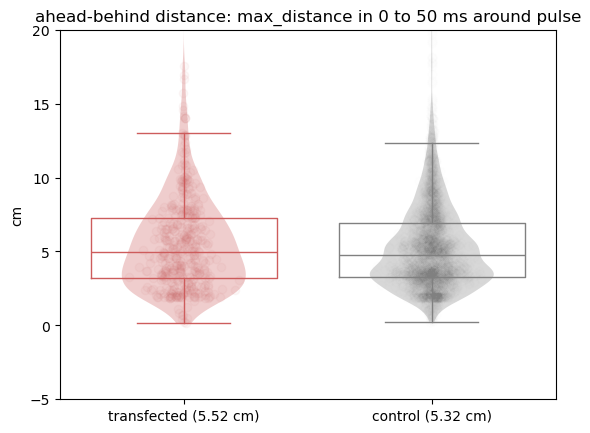

In [6]:
from ms_stim_analysis.Analysis.utils import violin_scatter

measure = "max_distance"
# measure="spread"

rng = -65, 65
rng = 0, 50
val_list = []
ind_test = np.logical_and(plot_ind * 2 > rng[0], plot_ind * 2 < rng[1])
for i, (animal, ahead_behind) in enumerate(
    zip(
        compiled_results["animal"],
        compiled_results["ahead_behind"],
    )
):
    color = animal_style.loc[animal]["color"]

    ahead_behind = ahead_behind[:, ind_test]
    ahead_behind = np.clip(ahead_behind, -20, 20)
    if measure == "max_distance":
        val = np.max(np.abs(ahead_behind), axis=1)
    elif measure == "spread":
        val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
    else:
        raise ValueError("Invalid measure: {}".format(measure))
    val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
    # val = np.clip(val, -20, 20)
    xloc = i
    violin_scatter(val, pos=[xloc], color=color, alpha=0.2)
    # plt.scatter([xloc], np.mean(val), color=color, alpha=0.5,edgecolors="k",lw=2,s=50)

    bplot = plt.boxplot(val, positions=[xloc], showfliers=False, widths=0.75)
    plt.setp(bplot["boxes"], color=color)
    plt.setp(bplot["whiskers"], color=color)
    plt.setp(bplot["caps"], color=color)
    plt.setp(bplot["medians"], color=color)
    plt.setp(bplot["means"], color=color)
    print(animal, np.mean(val))

    val_list.append(val)

plt.xticks(
    np.arange(len(compiled_results["animal"])),
    [
        f"{a} ({np.round(np.mean(d),2)} cm)"
        for a, d in zip(compiled_results["animal"], val_list)
    ],
)
plt.ylabel("cm")
plt.ylim(-5, 20)
from scipy.stats import ttest_ind

print(ttest_ind(val_list[0], val_list[1]).pvalue)

plt.title(f"ahead-behind distance: {measure} in {rng[0]} to {rng[1]} ms around pulse")

transfected 9.189362174308725
transfected 9.482565948838
control 9.615081221832492
control 8.590469442633601
0.5094625606176553


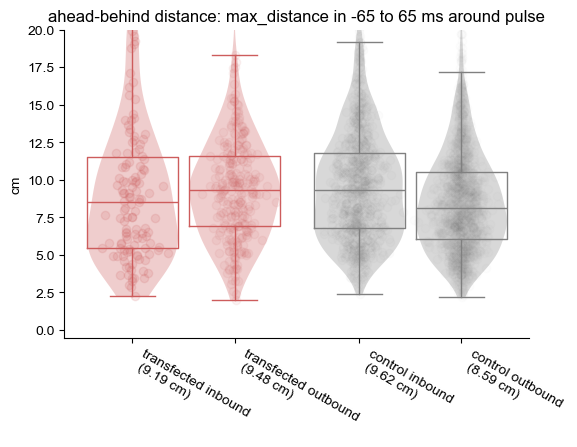

In [8]:
from ms_stim_analysis.Analysis.utils import violin_scatter

measure = "max_distance"
# measure="spread"


fig = plt.figure(figsize=(6, 4))
rng = -65, 65
# rng = 0, 30
val_list = []
ticks = []
labels = []
ind_test = np.logical_and(plot_ind * 2 > rng[0], plot_ind * 2 < rng[1])
for i, (animal, all_ahead_behind, inbound_stim, outbound_stim) in enumerate(
    zip(
        compiled_results["animal"],
        compiled_results["ahead_behind"],
        compiled_results["inbound_stim"],
        compiled_results["outbound_stim"],
    )
):
    color = animal_style.loc[animal]["color"]
    for j, (trial_type, trial_stim) in enumerate(
        zip(["inbound", "outbound"], [inbound_stim, outbound_stim])
    ):
        ahead_behind = all_ahead_behind[trial_stim][:, ind_test]

        ahead_behind = np.clip(ahead_behind, -20, 20)
        if measure == "max_distance":
            val = np.max(np.abs(ahead_behind), axis=1)
        elif measure == "spread":
            val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
        else:
            raise ValueError("Invalid measure: {}".format(measure))
        val = np.max(ahead_behind, axis=1) - np.min(ahead_behind, axis=1)
        # val = np.clip(val, -20, 20)
        xloc = i + j * 0.45
        violin_scatter(val, pos=[xloc], color=color, alpha=0.2, widths=0.4)
        # plt.scatter([xloc], np.mean(val), color=color, alpha=0.5,edgecolors="k",lw=2,s=50)

        bplot = plt.boxplot(val, positions=[xloc], showfliers=False, widths=0.4)
        plt.setp(bplot["boxes"], color=color)
        plt.setp(bplot["whiskers"], color=color)
        plt.setp(bplot["caps"], color=color)
        plt.setp(bplot["medians"], color=color)
        plt.setp(bplot["means"], color=color)
        print(animal, np.mean(val))

        val_list.append(val)
        ticks.append(xloc)
        labels.append(f"{animal} {trial_type} \n ({np.round(np.mean(val),2)} cm)")

# plt.xticks(
#     np.arange(len(compiled_results["animal"])),
#     [
#         f"{a} ({np.round(np.mean(d),2)} cm)"
#         for a, d in zip(compiled_results["animal"], val_list)
#     ],
# )
plt.xticks(ticks, labels, rotation=-30, ha="left")
plt.ylabel("cm")
plt.ylim(-5, 20)
from scipy.stats import ttest_ind

print(ttest_ind(val_list[0], val_list[1]).pvalue)

plt.title(f"ahead-behind distance: {measure} in {rng[0]} to {rng[1]} ms around pulse")
plt.rcParams["font.family"] = "Arial"
fig.gca().spines[["top", "right"]].set_visible(False)
ylim = fig.gca().get_ylim()
ylim = (-0.5, ylim[1])
plt.ylim(ylim)
plt.xlim(-0.3, ticks[-1] + 0.3)
fig.savefig(
    "../Figures/Fig_S3/Fig_S3g_wtrack_ahead_behind_per_pulse_distance_choice_point.svg",
    bbox_inches="tight",
)